In [6]:
Sys.getenv('R_LIBS_USER')

[1] "~/R/x86_64-pc-linux-gnu-library/4.1"

In [7]:
.libPaths('/scratch/saberi/R_4.1.2')

In [8]:
NUM_THREADS = 2

In [9]:
setwd('/scratch/saberi/isoseq/RTOpt')

In [10]:
library(data.table)
library(stringr)
library(parallel)
library(magrittr)
library(ggplot2)

In [11]:
setDTthreads(NUM_THREADS)

In [72]:
s = c(rep(c('L', 'M'), each = 4) , rep('N', 2))
v = rep(c(1, 2), each = 2)
r = c(1, 2)
sample_names = str_c(s, '.v', v, '.r', r) %>% suppressWarnings

In [118]:
sample_names

[1] "L.v1.r1" "L.v1.r2" "L.v2.r1" "L.v2.r2" "M.v1.r1" "M.v1.r2" "M.v2.r1"
 [8] "M.v2.r2" "N.v1.r1" "N.v1.r2"

In [119]:
.get_read_info = function(sn, reference = 'genome') {

    if(reference == 'genome') {
        read_info_list_file = str_glue('samples/{sn}/{sn}.clustered.hq.aln-gene.mm2.splice-hq.sorted.filtered.tsv') 
        read_info = fread(read_info_list_file, header = F, col.names = c('cluster_id', 'mapq', 'len'))

    } else if(reference == 'transcriptome') {
        read_info_list_file = str_glue('samples/{sn}/{sn}.clustered.hq.aln-tr.mm2.map-hifi.sorted.filtered.tsv')
        read_info = fread(read_info_list_file, header = F, col.names = c('cluster_id', 'mapq'))
    } else {
        print('ERROR: Wrong "reference"')
        return(NULL)
    }
    
    read_info[, sample := sn]
    
    cluster_info_file = str_glue('samples/{sn}/{sn}.clustered.cluster_report.csv', select = 2)
    cluster_info = fread(cluster_info_file)
    cluster_info = cluster_info[, .N, cluster_id]

    read_info = merge(read_info, cluster_info, by = 'cluster_id')
    
    read_info = merge(read_info,
                    read_info[, .(index = seq(N)), cluster_id],
                    by = 'cluster_id')

    read_info
    
}

In [120]:
read_infos = lapply(sample_names, .get_read_info)

In [121]:
ri_all = do.call(rbind, read_infos)

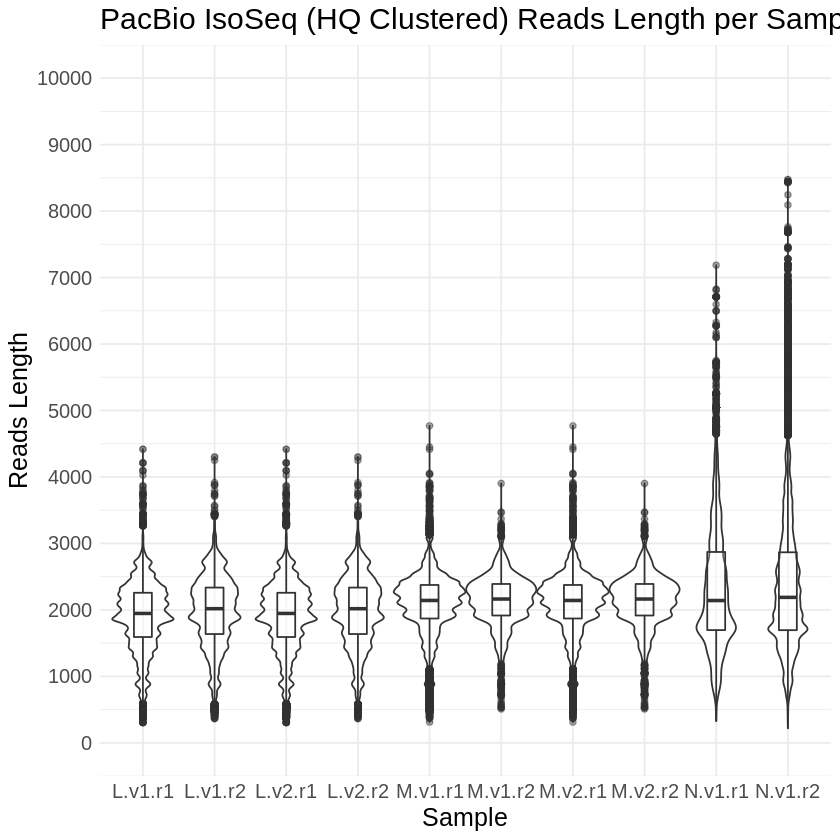

In [122]:
ggplot(ri_all) +
    aes(x = sample, y = len) +
    geom_violin(width = 1, position=position_dodge(2), alpha = 0.25) +
    geom_boxplot(width = 0.25, alpha = 0.25) +
    theme_minimal() +
    theme(text=element_text(size=15)) + 
    labs(title = 'PacBio IsoSeq (HQ Clustered) Reads Length per Sample') +
    xlab('Sample') +
    scale_y_continuous(name = 'Reads Length', limits = c(0, 1e4), breaks = seq(0, 1e4, 1e3))

In [82]:
ggsave('plots/read_len.png', width = 10, height = 10, dpi = 300)

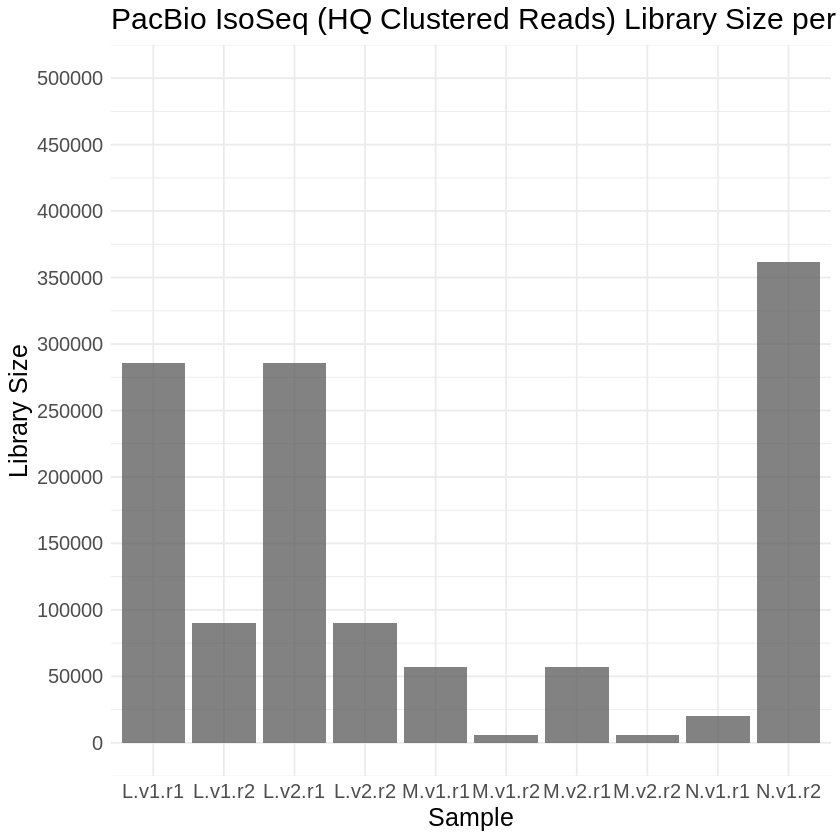

In [127]:
ggplot(ri_all[, .N, sample]) +
    aes(x = sample, y = N) +
    geom_bar(stat="identity", alpha = 0.75) +
    theme_minimal() +
    theme(text=element_text(size=15)) + 
    labs(title = 'PacBio IsoSeq (HQ Clustered Reads) Library Size per Sample') +
    xlab('Sample') +
    scale_y_continuous(name = 'Library Size', limits = c(0, 5e5), breaks = seq(0, 5e5, 0.5e5))

In [128]:
ggsave('plots/lib_size.png', width = 10, height = 10, dpi = 300)

---

# MAPQ

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



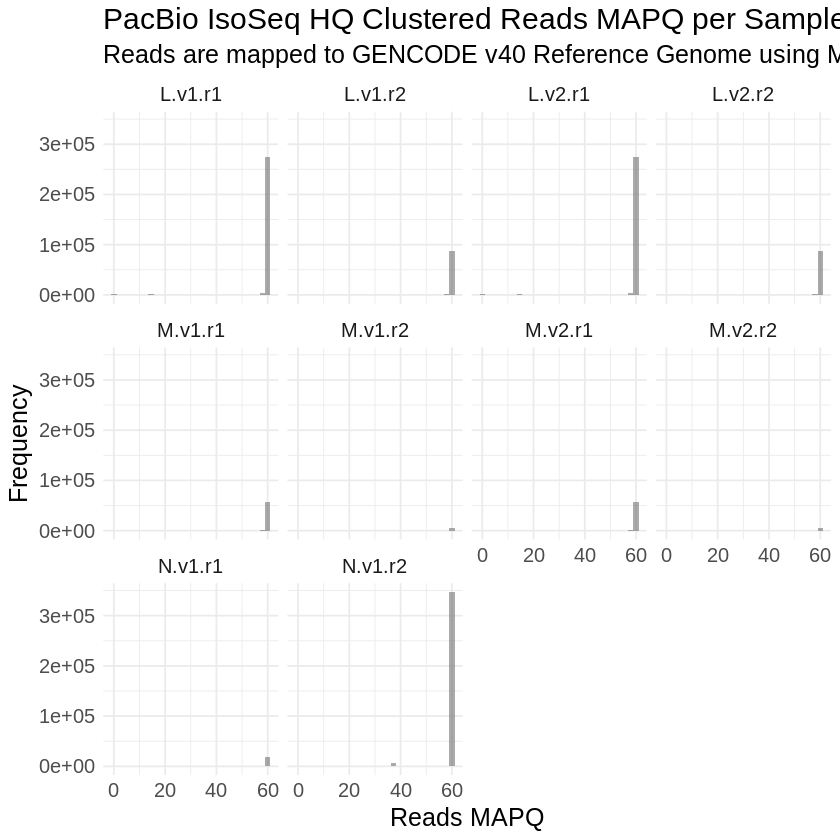

In [90]:
ggplot(ri_all) +
    aes(x = mapq) +
    geom_histogram(alpha = 0.5) +
    facet_wrap(~sample) +
    theme_minimal() +
    theme(text=element_text(size=15)) + 
    labs(title = 'PacBio IsoSeq HQ Clustered Reads MAPQ per Sample',
        subtitle = 'Reads are mapped to GENCODE v40 Reference Genome using Minimap2') +
    xlab('Reads MAPQ') +
    ylab('Frequency')

In [91]:
ggsave('plots/read_mapq.genome.png', width = 10, height = 10, dpi = 300)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [123]:
read_infos_tr = lapply(sample_names, .get_read_info, reference = 'transcriptome')

In [124]:
ri_all_tr = do.call(rbind, read_infos_tr)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



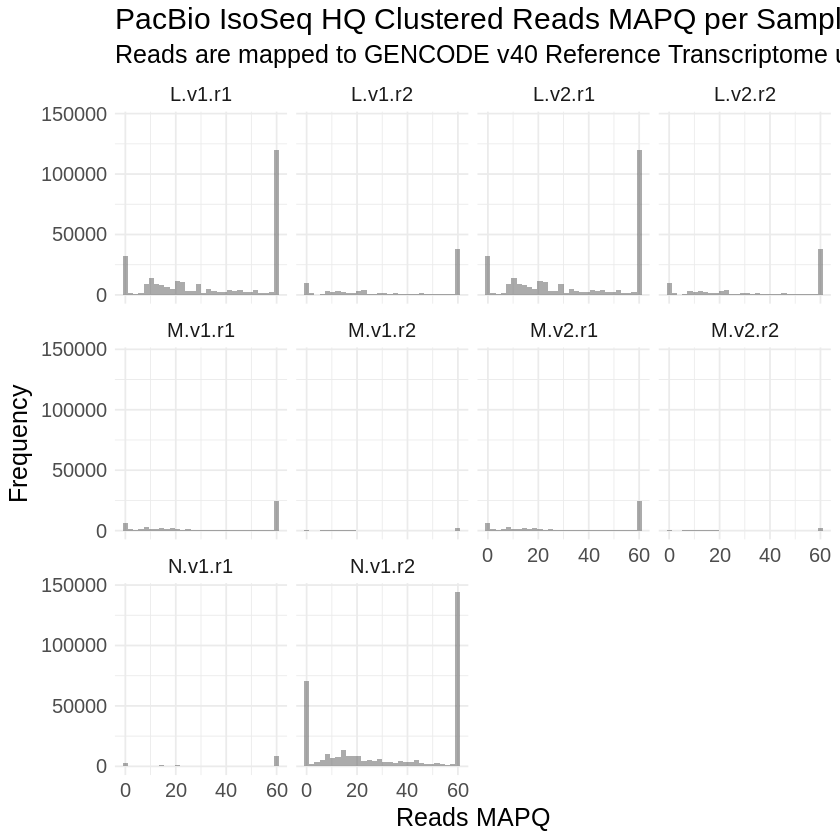

In [125]:
ggplot(ri_all_tr) +
    aes(x = mapq) +
    geom_histogram(alpha = 0.5) +
    facet_wrap(~sample) +
    theme_minimal() +
    theme(text=element_text(size=15)) + 
    labs(title = 'PacBio IsoSeq HQ Clustered Reads MAPQ per Sample',
        subtitle = 'Reads are mapped to GENCODE v40 Reference Transcriptome using Minimap2') +
    xlab('Reads MAPQ') +
    ylab('Frequency')

In [126]:
ggsave('plots/read_mapq.transcriptome.png', width = 10, height = 10, dpi = 300)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

